In [54]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.neural_network import MLPClassifier
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.metrics import classification_report, auc, roc_auc_score, confusion_matrix, accuracy_score, f1_score, matthews_corrcoef, roc_curve

In [55]:
# Read the cleaned data into a dataframe
X = pd.read_csv("../data/processed/X.csv")
y = pd.read_csv("../data/processed/Y.csv")

In [5]:
X.shape

(328977, 25)

In [11]:
parameters = [{
                'hidden_layer_sizes': [(3,),(5,),(7,)],
                'activation': ['identity', 'logistic', 'tanh', 'relu'],
                'solver':['adam'], 'alpha':[0.00001, 0.0001, 0.001],
                'learning_rate':['constant', 'invscaling', 'adaptive']
             }]

xTrain, xTest, yTrain, yTest = train_test_split(X, y)

clf = GridSearchCV(MLPClassifier(), parameters, cv=5, verbose=1)
clf.fit(xTrain, yTrain.values.ravel())

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 540 out of 540 | elapsed: 304.4min finished


GridSearchCV(cv=5, estimator=MLPClassifier(),
             param_grid=[{'activation': ['identity', 'logistic', 'tanh',
                                         'relu'],
                          'alpha': [1e-05, 0.0001, 0.001],
                          'hidden_layer_sizes': [(3,), (5,), (7,)],
                          'learning_rate': ['constant', 'invscaling',
                                            'adaptive'],
                          'solver': ['sgd']}],
             verbose=1)

In [12]:
clf.best_params_

{'activation': 'tanh',
 'alpha': 0.001,
 'hidden_layer_sizes': (5,),
 'learning_rate': 'adaptive',
 'solver': 'sgd'}

In [16]:
clf.best_score_

0.9398253957188316

In [17]:
clf.n_splits_

5

In [18]:
yPred = clf.predict(xTest)

In [51]:
MLP_Metrics = classification_report(yTest, yPred)
print(MLP_Metrics)

# Save this information to a text file, just in case
with open("../plots/MLPClassifier_Info.txt", "w") as text_file:
    print("Best Parameters:\n{}\n\nMLPClassifier Metrics:\n{}".format(clf.best_params_, MLP_Metrics), file=text_file)

              precision    recall  f1-score   support

           0       0.96      0.97      0.97     75442
           1       0.64      0.59      0.61      6803

    accuracy                           0.94     82245
   macro avg       0.80      0.78      0.79     82245
weighted avg       0.94      0.94      0.94     82245



### Re-run using the best parameters
The correct parameters are found in Project.ipynb

This is run using 5 Stratified K-Folds and records the metrics so that we can plot them

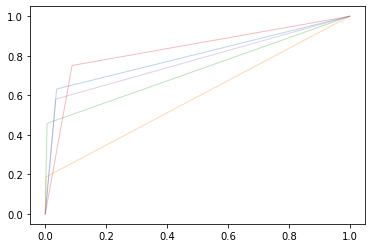

In [170]:
from numpy import interp

skf = StratifiedKFold(n_splits=5)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
acc = []
f1 = []
mcc = []
cm = []
input_weight_df = pd.DataFrame()
metric_reports = pd.DataFrame()
i =1

for trainIndex, textIndex in skf.split(X, y):
    xTrain, xTest = X.iloc[trainIndex], X.iloc[textIndex]
    yTrain, yTest = y.iloc[trainIndex], y.iloc[textIndex]

    clf = MLPClassifier(hidden_layer_sizes=(7,), activation='tanh', solver='adam', alpha=0.001, learning_rate = 'adaptive', random_state = 2020)
    clf.fit(xTrain, yTrain.values.ravel())  

    yPred = clf.predict(xTest)

    # All Scores
    acc.append(accuracy_score(yTest, yPred))
    f1.append(f1_score(yPred,yTest))
    mcc.append(matthews_corrcoef(yTest, yPred))
    cm.append(confusion_matrix(yTest,yPred))
    
    #Classification reports
    rpt = pd.DataFrame(classification_report(yTest, yPred,  output_dict=True)).transpose()
    rpt['Fold'] = i
    metric_reports = metric_reports.append(rpt)
    
    # Input Layer Weights
    for j in range(len(clf.coefs_[0])):
        input_weight_df.loc[str(X.columns[j]),"Fold {}".format(i)] = clf.coefs_[0][j][0]


    # ROC Curve
    fpr, tpr, thresholds = roc_curve(yTest, yPred)
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i = i+1

### Plot results

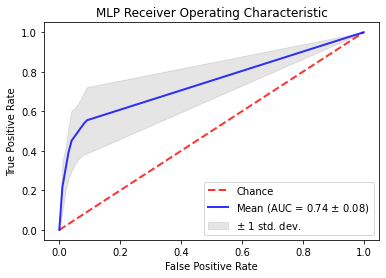

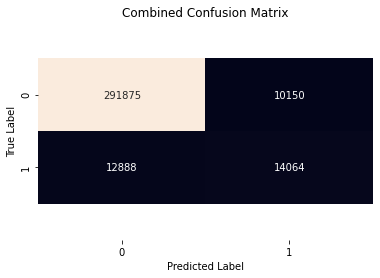

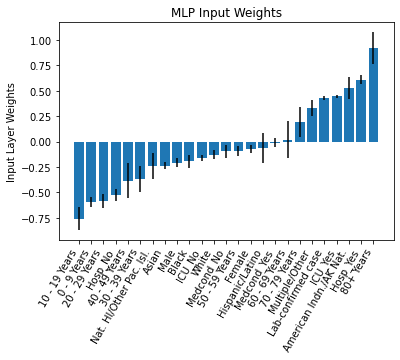

,precision,recall,f1-score,support
0,0.9584 ± 0.0167,0.9664 ± 0.0344,0.9618 ± 0.0113,60405.0 ± 0.0
1,0.6773 ± 0.1943,0.5218 ± 0.2146,0.5331 ± 0.1281,5390.4 ± 0.5477
accuracy,0.93 ± 0.0189,0.93 ± 0.0189,0.93 ± 0.0189,0.93 ± 0.0189
macro avg,0.8179 ± 0.0898,0.7441 ± 0.0931,0.7475 ± 0.0647,65795.4 ± 0.5477
weighted avg,0.9353 ± 0.0075,0.93 ± 0.0189,0.9267 ± 0.0153,65795.4 ± 0.5477


In [179]:
# Plot the ROC and AUCs of each Fold
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('MLP Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
  

# Add each fold's results to get the combined Confusion Matrix
tp = fp = fn = tn = 0
for m in cm:
    tp += m[0][0]
    fp += m[0][1]
    
    fn += m[1][0]
    tn += m[1][1]
    
finalCM = [[tp, fp], [fn, tn]]

# Show the confusion matrix
ax = sns.heatmap(finalCM, annot=True, cbar=False, fmt='g')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Combined Confusion Matrix')
plt.show()

input_weight_df.transpose()
avg_weights = pd.DataFrame(input_weight_df.transpose().mean(), columns = ["Input Layer Weight"])
avg_weights["std deviation"] = input_weight_df.transpose().std()

compare_names = pd.DataFrame()
compare_names["Before"] = avg_weights.index

# Rename to make it easier to read
avg_weights.index = ['Lab-confirmed case', 'Female', 'Male',\
       '0 - 9 Years', '10 - 19 Years',\
       '20 - 29 Years', '30 - 39 Years',\
       '40 - 49 Years', '50 - 59 Years',\
       '60 - 69 Years', '70 - 79 Years',\
       '80+ Years',\
       'American Indn./AK Nat.',\
       'Asian',\
       'Black',\
       'Hispanic/Latino',\
       'Multiple/Other',\
       'Nat. HI/Other Pac. Isl.',\
       'White', 'Hosp_No',\
       'Hosp_Yes', 'ICU_No', 'ICU_Yes', 'Medcond_No',\
       'Medcond_Yes']
compare_names["After"] = avg_weights.index
# You can run this to easily see that nothing was mis-labeled
# print(compare_names, '\n\n')

# Plot the input layer weights
avg_weights = avg_weights.sort_values('Input Layer Weight')
plt.bar(avg_weights.index, avg_weights.loc[:,'Input Layer Weight'], yerr=avg_weights.loc[:,"std deviation"], ecolor='black', align='center')
plt.ylabel('Input Layer Weights')
plt.xticks(rotation=60, horizontalalignment = 'right')
plt.savefig('../plots/MLP_ILayerWeights')
plt.title("MLP Input Weights")
plt.show()


# Plot the average from the metric reports
meandf_c = metric_reports.groupby(metric_reports.index).mean()
sddf_c = metric_reports.groupby(metric_reports.index).std()

resdf_c = round(meandf_c.loc[:,'precision':'support'],4).astype(str)+ " ± "+\
    round(sddf_c.loc[:,'precision':'support'],4).astype(str)

# Save the metrics to a csv
resdf_c.to_csv("../plots/MLP_Metrics.csv")
resdf_c